In [1]:
import requests
import pandas as pd
import time
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import datasets
from scipy import stats
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections import register_projection
from matplotlib.projections.polar import PolarAxes
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:


POKE_LIMIT = 386  # first 3 gens; 

poke_index_url = f"https://pokeapi.co/api/v2/pokemon?limit={POKE_LIMIT}"
poke_index = requests.get(poke_index_url).json()['results'] 
pokemon_rows = []

for p in poke_index:
    data = requests.get(p['url']).json()
    
    row = {
        'pokemon_id': data['id'],
        'name':       data['name'],
        'height_dm':  data['height'],      
        'weight_hg':  data['weight'],      
        'order':      data['order']
    }

    # --- stats ---
    for s in data['stats']:                       # hp/attack/defense/sp.atk/ ect
        stat_name        = s['stat']['name']      # e.g. 'hp'
        row[f"base_{stat_name}"] = s['base_stat'] # 45 

    # --- types (slot 1 = primary, slot 2 = secondary) ---
    for t in data['types']:
        slot = t['slot']                          # 1 or 2
        row[f"type_{slot}"] = t['type']['name']   # 'grass', fire, water ect 

    pokemon_rows.append(row)
    time.sleep(0.1)  # 10 req/s this will not throttle or ban the API, 


In [3]:
# We will set the rows from the API in to a DataFram
df_pokemon = pd.DataFrame(pokemon_rows)
df_pokemon.head()

#rename come columsn to better suit us like height_dm to Height, weight_hg to weight, ect
df_pokemon = df_pokemon.rename(
        columns= {'pokemon_id': 'Pokemon_ID','name': "Name",'height_dm' : 'Height', 'weight_hg' : "Weight", 
                  'order' : "Pokedex ID", 'base_hp': "Base_HP", 'base_attack' : "Base_Attack", 
                 'base_defense' : "Base_Defense", 'base_special_attack' : "Base_Special_Attack",
                 'base_special_defense':'Base_Special_Defense', 'base_speed' : "Base_Speed",
                 'type_1' : "Primary Type", 'type_2' : "Secondary Type"})
df_pokemon= df_pokemon.drop( 'Pokedex ID', axis = 1)
df_pokemon = df_pokemon.set_index('Pokemon_ID')
df_pokemon.head()

,Name,Height,Weight,Base_HP,Base_Attack,Base_Defense,base_special-attack,base_special-defense,Base_Speed,Primary Type,Secondary Type
Pokemon_ID,,,,,,,,,,,
1,bulbasaur,7,69,45,49,49,65,65,45,grass,poison
2,ivysaur,10,130,60,62,63,80,80,60,grass,poison
3,venusaur,20,1000,80,82,83,100,100,80,grass,poison
4,charmander,6,85,39,52,43,60,50,65,fire,NaN
5,charmeleon,11,190,58,64,58,80,65,80,fire,NaN


In [4]:
#Lets get teh general count and see any odd outlyers
print('Describe')
print(df_pokemon.describe())

Describe
           Height       Weight     Base_HP  Base_Attack  Base_Defense  \
count  386.000000   386.000000  386.000000   386.000000    386.000000   
mean    11.987047   541.572539   66.474093    71.777202     68.878238   
std     11.933249   844.427701   28.239893    28.496563     30.619461   
min      2.000000     1.000000    1.000000     5.000000      5.000000   
25%      6.000000    99.250000   50.000000    50.000000     48.250000   
50%     10.000000   292.500000   63.500000    70.000000     65.000000   
75%     15.000000   600.000000   80.000000    90.000000     85.000000   
max    145.000000  9500.000000  255.000000   160.000000    230.000000   

       base_special-attack  base_special-defense  Base_Speed  
count           386.000000            386.000000  386.000000  
mean             66.707254             67.839378   64.476684  
std              27.674261             27.833552   27.212883  
min              10.000000             20.000000    5.000000  
25%              4

In [5]:
#see if there is any NA's in the stats column, secondary Type if fine to have NA; not all pokemon Have a secondary type
df_pokemon.isnull().sum()

Name                      0
Height                    0
Weight                    0
Base_HP                   0
Base_Attack               0
Base_Defense              0
base_special-attack       0
base_special-defense      0
Base_Speed                0
Primary Type              0
Secondary Type          204
dtype: int64

In [6]:
# Grouping the DataFrame by "Primary Type"
type_group = df_pokemon.groupby("Primary Type")

# Count how many pokemon were in each type based on type one
type_group = pd.DataFrame(type_group["Primary Type"].value_counts())
type_group

,,Primary Type
Primary Type,Primary Type,
bug,bug,34
dark,dark,9
dragon,dragon,10
electric,electric,19
fairy,fairy,7
fighting,fighting,13
fire,fire,26
ghost,ghost,8
grass,grass,33


In [7]:
#lets see the mean of each stat based on type in a DataFrame
df_1 = df_pokemon.groupby(['Primary Type'])
df_1.mean()

,Height,Weight,Base_HP,Base_Attack,Base_Defense,base_special-attack,base_special-defense,Base_Speed
Primary Type,,,,,,,,
bug,8.882353,256.558824,53.764706,62.500000,66.000000,48.235294,63.058824,56.911765
dark,8.444444,235.000000,61.111111,82.777778,58.555556,66.666667,65.777778,73.444444
dragon,22.700000,812.100000,73.800000,97.700000,79.500000,89.000000,81.500000,79.500000
electric,8.526316,334.736842,57.368421,59.263158,56.789474,85.526316,68.684211,87.631579
fairy,7.285714,159.571429,65.000000,57.142857,60.571429,60.000000,68.571429,35.000000
fighting,12.000000,639.923077,64.307692,86.923077,59.769231,41.923077,67.692308,60.230769
fire,12.346154,611.346154,65.076923,81.807692,66.230769,85.153846,72.846154,71.192308
ghost,11.500000,127.625000,45.375000,63.750000,64.375000,83.250000,70.750000,66.250000
grass,9.606061,280.000000,62.393939,68.606061,63.121212,76.272727,65.969697,58.363636


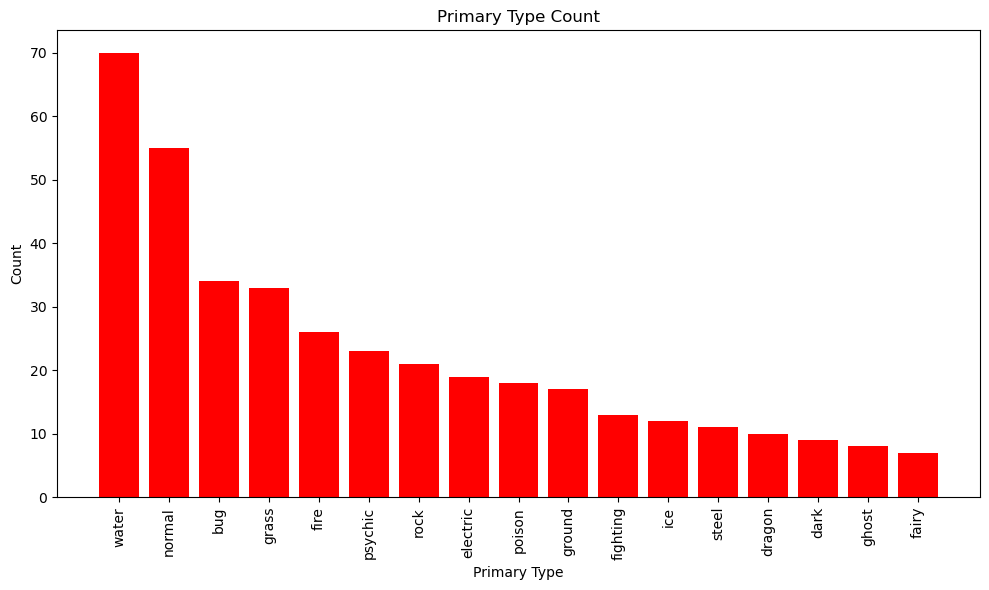

In [8]:
# Count the number of Pokémon per Primary Type in a bar chart
type_counts = df_pokemon['Primary Type'].value_counts()

# Plot
plt.figure(figsize=(10,6))
#we will use type_counts.index for a count of each unique value 'this would be type like "water, fire ect"', 
#and type_count.index will give use the count on the y axis as a number
plt.bar(type_counts.index, type_counts.values, color='red')


plt.title('Primary Type Count')
plt.ylabel('Count')
plt.xlabel('Primary Type')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [9]:
# Grouping the DataFrame by "Primary Type"
type_group_secondary = df_pokemon.groupby("Secondary Type")

# Count how many pokemon were in each type based on type 2 or secondary type
type_group2 = pd.DataFrame(type_group_secondary["Secondary Type"].value_counts())
type_group2

,,Secondary Type
Secondary Type,Secondary Type,
bug,bug,2
dark,dark,7
dragon,dragon,3
electric,electric,2
fairy,fairy,11
fighting,fighting,5
fire,fire,2
flying,flying,50
ghost,ghost,2


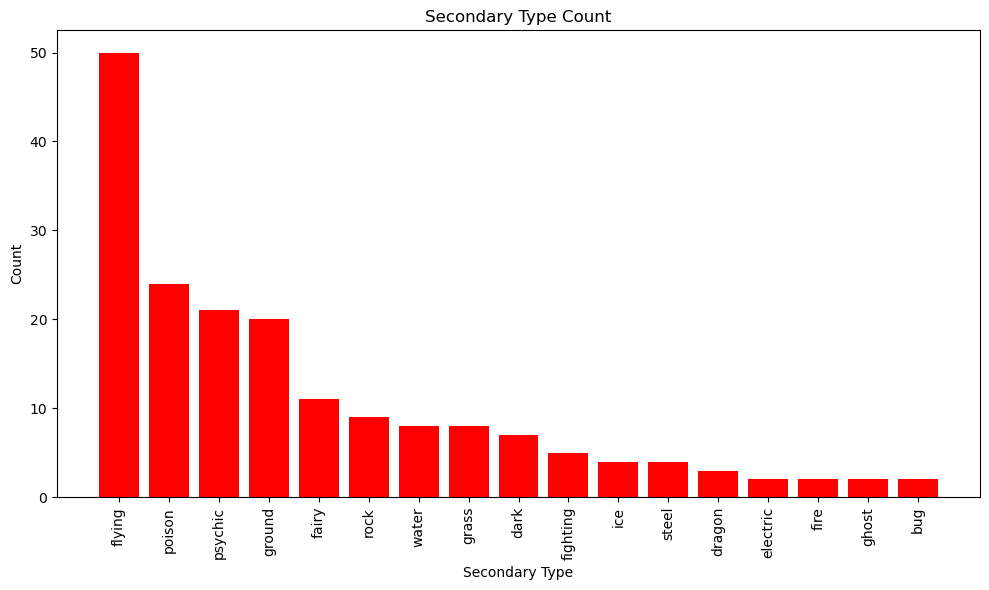

In [10]:
# Count the number of Pokémon per Primary Type
type_counts = df_pokemon['Secondary Type'].value_counts()

# Plot
plt.figure(figsize=(10,6))
#we will use type_counts.index for a count of each unique value 'this would be type like "water, fire ect"', 
#and type_count.index will give use the count on the y axis as a number, counting the Secondary type
plt.bar(type_counts.index, type_counts.values, color='red')


plt.title('Secondary Type Count')
plt.ylabel('Count')
plt.xlabel('Secondary Type')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

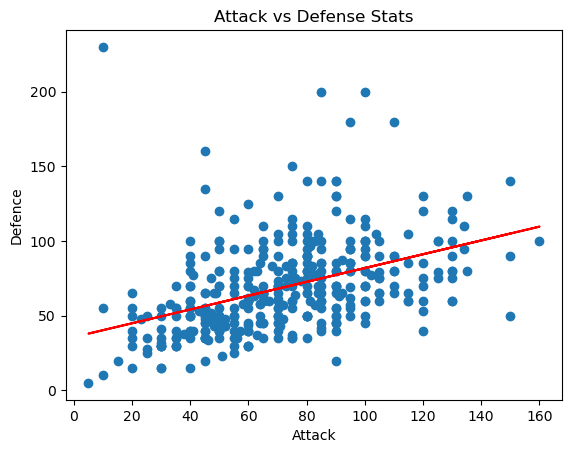

In [11]:
#scatter plot of attack and defense with a line regression
x= df_pokemon['Base_Attack']
y = df_pokemon['Base_Defense']

# Perform a linear regression on year versus petrol-electric cars
slope, intercept, r, p, std_err = stats.linregress(x, y)
# Create equation of line to calculate predicted number of petrol-electric cars
regression  = slope * x + intercept



plt.scatter(x,y)
#could add a line showing a decase in attack while defnce increase
plt.title('Attack vs Defense Stats')
plt.ylabel('Defence')
plt.xlabel("Attack")
plt.plot(x, regression, color='red', label=f'Fit line: y={slope:.2f}x+{intercept:.2f}')
plt.show()

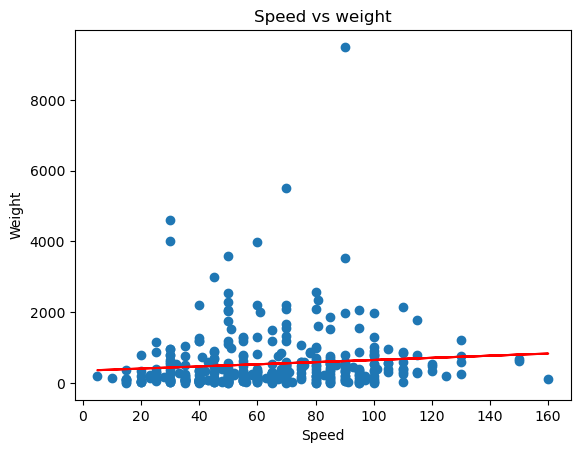

In [12]:
#scatter plot of speed and weight with a regression Line
x= df_pokemon['Base_Speed']
y = df_pokemon['Weight']

slope, intercept, r, p, std_err = stats.linregress(x, y)
# Create equation of line to calculate predicted number of petrol-electric cars
regression  = slope * x + intercept

plt.scatter(x,y)
#could add a line showing a decase in attack while defnce increase
plt.title('Speed vs weight')
plt.ylabel('Weight')
plt.xlabel("Speed")
plt.plot(x, regression, color='red', label=f'Fit line: y={slope:.2f}x+{intercept:.2f}')

plt.show()

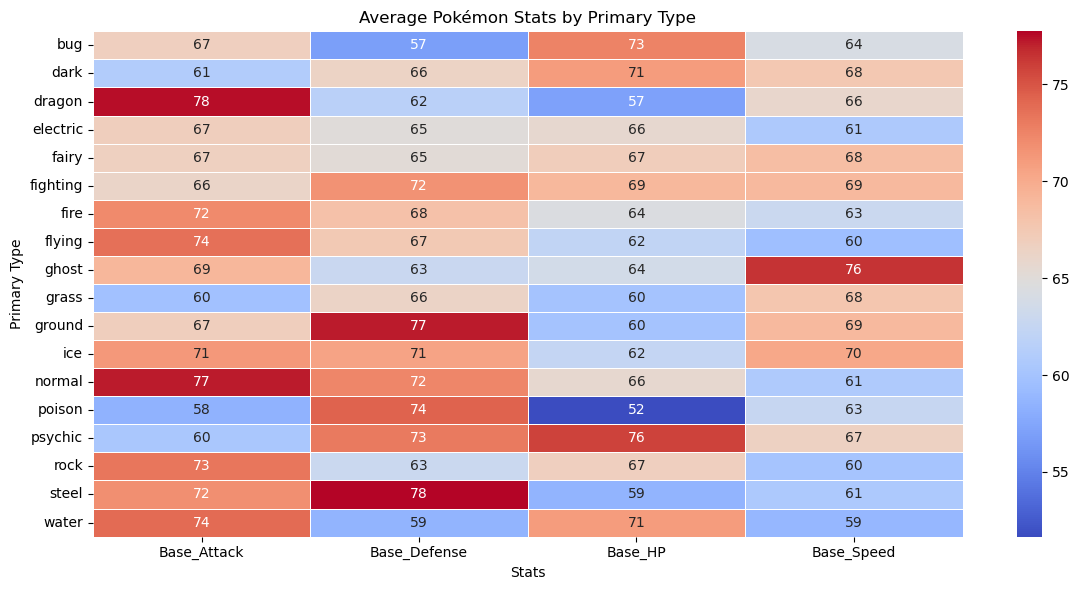

In [13]:
#This is a heat map of stats per Primary Types, the stats would be Attack, Defense, Speed and HP
#set seed to 0 so replication is possable 
np.random.seed(0)
sample_types = ['bug', 'dark', 'dragon', 'electric', 'fairy', 'fighting', 'fire', 'ghost', 'grass',
               'ground', 'ice', 'normal', 'poison', 'psychic', 'rock', 'steel', 'water', 'flying']

df_pokemonhm = pd.DataFrame({
    'name': [f'Pokemon_{i}' for i in range(386)],
    # use np.clip to keeping it realistic and valid and match the real mean and spread
    #loc = avg, std = scale, size = 386, .astype( min of that stat , max of that stat)
    'Base_HP': np.clip(np.random.normal(loc=66, scale=28, size=386).astype(int), 1, 255), 
    'Base_Attack': np.clip(np.random.normal(loc=72, scale=28, size=386).astype(int), 5, 160),
    'Base_Defense': np.clip(np.random.normal(loc=67, scale=30, size=386).astype(int), 5, 230),
    'Base_Speed': np.clip(np.random.normal(loc=65, scale=27, size=386).astype(int), 5, 160),
    'type_1': np.random.choice(sample_types, 386)
})

stats = ['Base_HP', 'Base_Attack', 'Base_Defense', 'Base_Speed']

heatmap_data = (
    df_pokemonhm
    .pivot_table(index='type_1', values=stats, aggfunc='mean')
    .sort_index()
)
#plt the figure 
plt.figure(figsize=(12,6))
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Average Pokémon Stats by Primary Type')
plt.ylabel('Primary Type')
plt.xlabel('Stats')
plt.tight_layout()
plt.show()

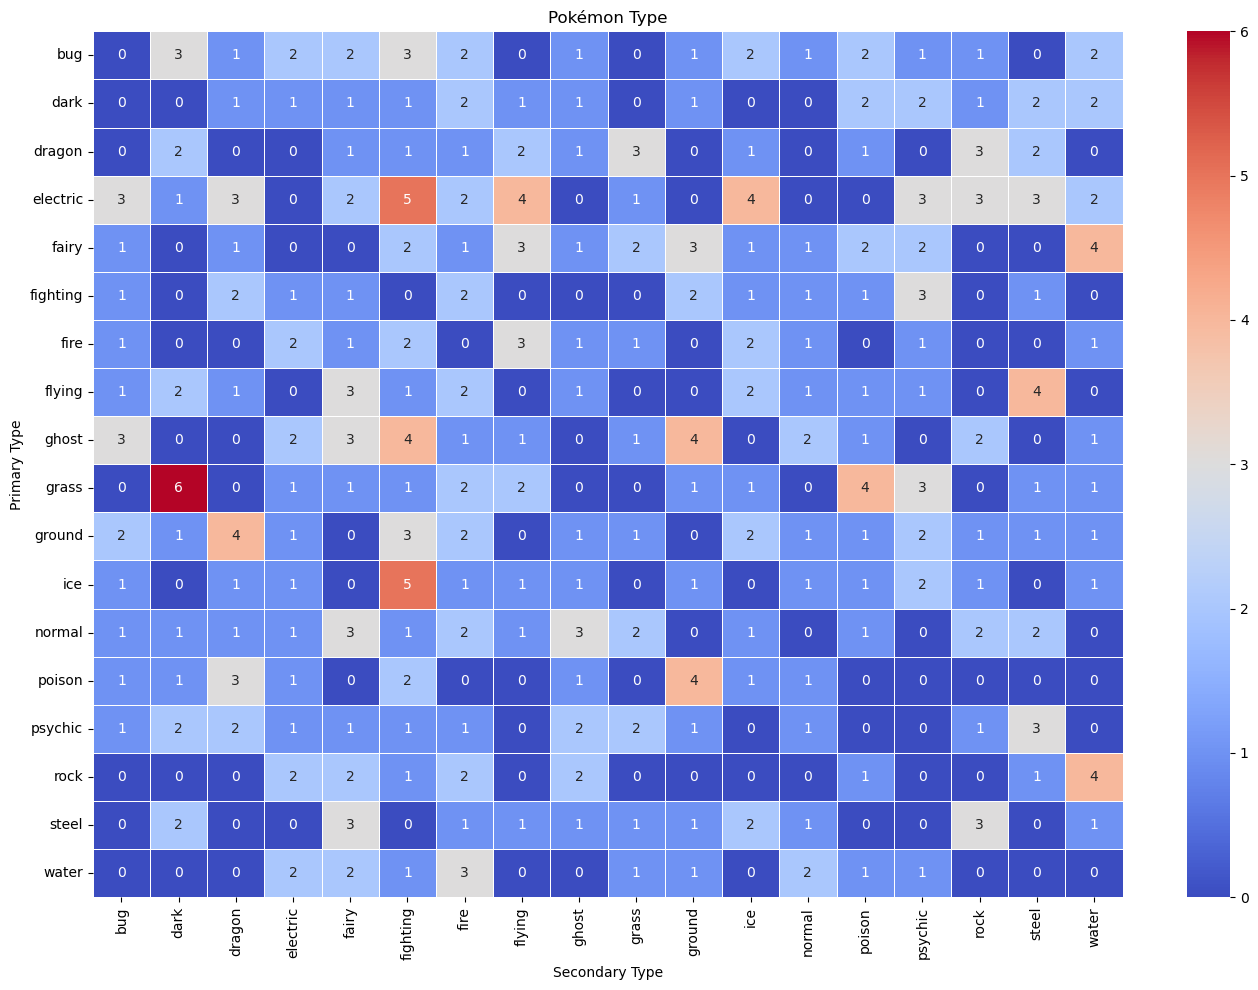

In [14]:
#create a heat map of Type and secondary type, lets explore if one type and one secondary is common or non-exstiance
np.random.seed(0)
sample_types = ['bug', 'dark', 'dragon', 'electric', 'fairy', 'fighting', 'fire', 'ghost', 'grass',
               'ground', 'ice', 'normal', 'poison', 'psychic', 'rock', 'steel', 'water', 'flying']

df_pokemonhm2 = pd.DataFrame({
    
    'type_1': np.random.choice(sample_types, 386),
    'type_2': np.random.choice(sample_types, 386)
})
#this gets rid of dulipcats of 'Fire' and 'Fire', this stats that type 1 MUST be different then secondary type
df_pokemonhm2 = df_pokemonhm2[df_pokemonhm2['type_1'] != df_pokemonhm2['type_2']]

heatmap_data = (
    df_pokemonhm2
    .pivot_table(index='type_1', columns= 'type_2', aggfunc='size', fill_value=0)
    .sort_index()
)

#Plt the heatmap with labels
plt.figure(figsize=(14,10))
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Pokémon Type')
plt.ylabel('Primary Type')
plt.xlabel('Secondary Type')
plt.tight_layout()
plt.show()

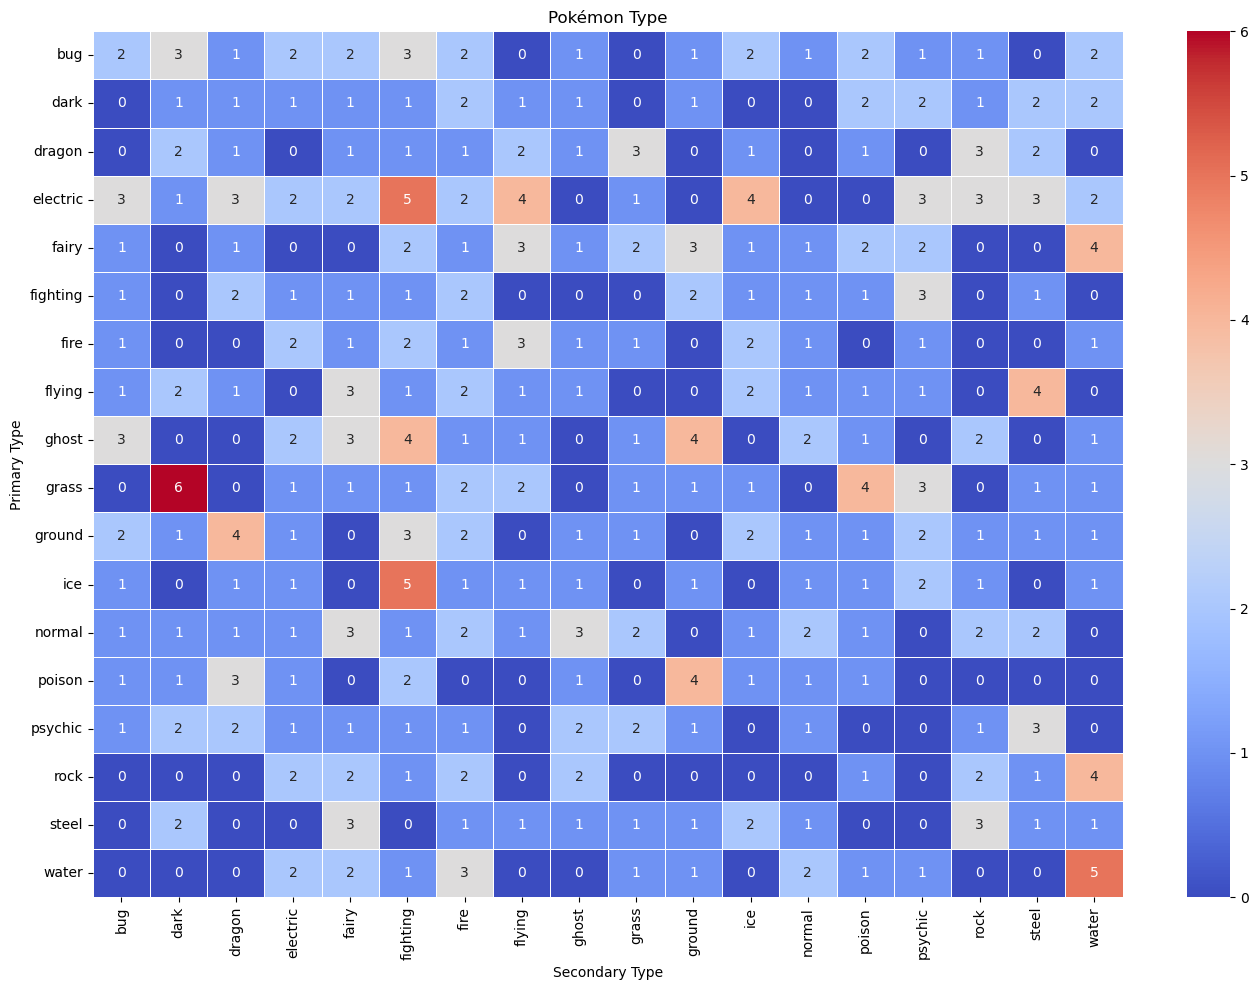

In [15]:
#creates a heat map of the one above but allows for primary and seconady type to be the same 
np.random.seed(0)
sample_types = ['bug', 'dark', 'dragon', 'electric', 'fairy', 'fighting', 'fire', 'ghost', 'grass',
               'ground', 'ice', 'normal', 'poison', 'psychic', 'rock', 'steel', 'water', 'flying']

df_pokemonhm3 = pd.DataFrame({
    
    'type_1': np.random.choice(sample_types, 386),
    'type_2': np.random.choice(sample_types, 386)
})


heatmap_data = (
    df_pokemonhm3
    .pivot_table(index='type_1', columns= 'type_2', aggfunc='size', fill_value=0)
    .sort_index()
)

plt.figure(figsize=(14,10))
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Pokémon Type')
plt.ylabel('Primary Type')
plt.xlabel('Secondary Type')
plt.tight_layout()
plt.show()

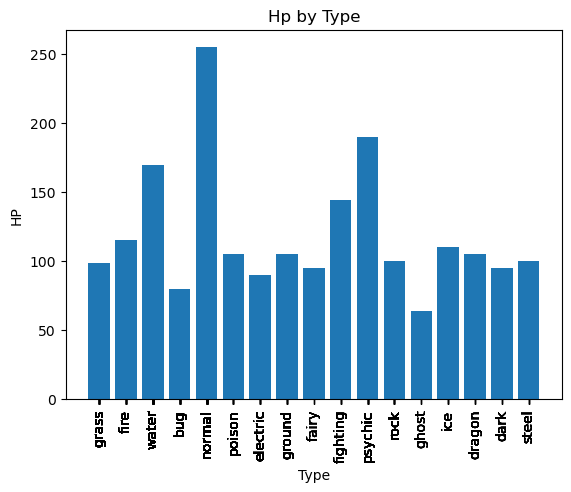

In [16]:
# bar chart of HP base on Primary Pokemon Type 
x= df_pokemon['Primary Type']
y = df_pokemon['Base_HP']

plt.bar(x,y)

plt.title('Hp by Type')
plt.ylabel('HP')
plt.xlabel("Type")
plt.xticks(x, rotation=90)
plt.show()

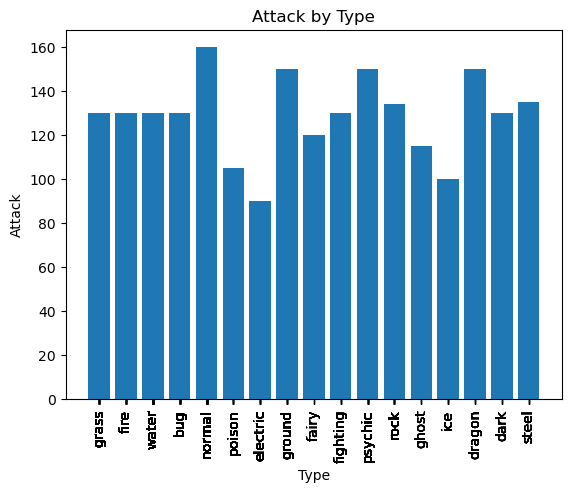

In [17]:
# bar chart of Attack base on Primary Pokemon Type 

x= df_pokemon['Primary Type']
y = df_pokemon['Base_Attack']

plt.bar(x,y)

plt.title('Attack by Type')
plt.ylabel('Attack')
plt.xlabel("Type")
plt.xticks(x, rotation=90)
plt.show()

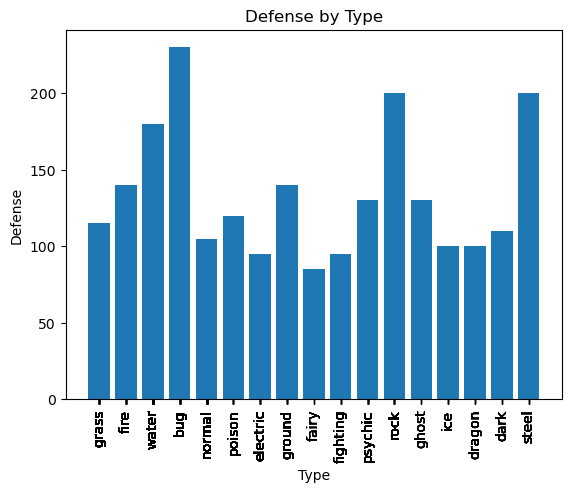

In [18]:
# bar chart of Defense base on Primary Pokemon Type 

x= df_pokemon['Primary Type']
y = df_pokemon['Base_Defense']

plt.bar(x,y)

plt.title('Defense by Type')
plt.ylabel('Defense')
plt.xlabel("Type")
plt.xticks(x, rotation=90)
plt.show()

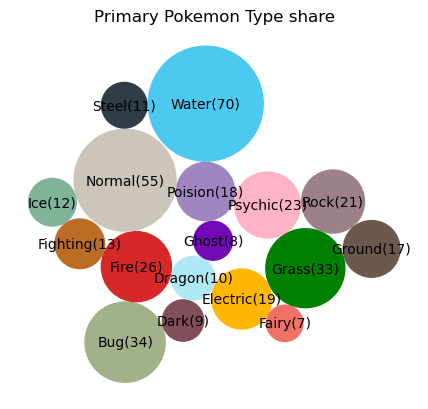

In [19]:
#bubble chart of Primary pokemon Type, browser_market_share = {Primary type [types, type2, ect], 
#[market share : [numbertype1, numbertype2, ect], color : [colors, color2,]]}
browser_market_share = {
    'Type': ['Bug(34)', 'Dark(9)', 'Dragon(10)', 'Electric(19)', 'Fairy(7)', 'Fighting(13)', 'Fire(26)',
                 'Ghost(8)', 'Grass(33)', 'Ground(17)', 'Ice(12)', 'Normal(55)', 'Poision(18)',
                 'Psychic(23)', 'Rock(21)', 'Steel(11)', 'Water(70)'],
    'market_share': [34, 9, 10, 19, 7, 13,26, 8, 33, 17, 12, 55, 18, 23,21, 11, 70 ],
    'color': ['#A3b18A', '#804F5A', '#ADe8F4', '#FFB703', '#F07167', '#BC6C25', '#D62828', '#7209B7', '#008000',
             '#6c584C', '#81B29A', '#CCC5b9', '#9F86c0', '#FFB3C6', '#9D8189', '#2F3E46', '#4CC9f0']
}


class BubbleChart:
    def __init__(self, area, bubble_spacing=0):
        """
        Setup for bubble collapse.

        Parameters
        ----------
        area : array-like
            Area of the bubbles.
        bubble_spacing : float, default: 0
            Minimal spacing between bubbles after collapsing.

        Notes
        -----
        If "area" is sorted, the results might look weird.
        """
        area = np.asarray(area)
        r = np.sqrt(area / np.pi)

        self.bubble_spacing = bubble_spacing
        self.bubbles = np.ones((len(area), 4))
        self.bubbles[:, 2] = r
        self.bubbles[:, 3] = area
        self.maxstep = 2 * self.bubbles[:, 2].max() + self.bubble_spacing
        self.step_dist = self.maxstep / 2

        # calculate initial grid layout for bubbles
        length = np.ceil(np.sqrt(len(self.bubbles)))
        grid = np.arange(length) * self.maxstep
        gx, gy = np.meshgrid(grid, grid)
        self.bubbles[:, 0] = gx.flatten()[:len(self.bubbles)]
        self.bubbles[:, 1] = gy.flatten()[:len(self.bubbles)]

        self.com = self.center_of_mass()

    def center_of_mass(self):
        return np.average(
            self.bubbles[:, :2], axis=0, weights=self.bubbles[:, 3]
        )

    def center_distance(self, bubble, bubbles):
        return np.hypot(bubble[0] - bubbles[:, 0],
                        bubble[1] - bubbles[:, 1])

    def outline_distance(self, bubble, bubbles):
        center_distance = self.center_distance(bubble, bubbles)
        return center_distance - bubble[2] - \
            bubbles[:, 2] - self.bubble_spacing

    def check_collisions(self, bubble, bubbles):
        distance = self.outline_distance(bubble, bubbles)
        return len(distance[distance < 0])

    def collides_with(self, bubble, bubbles):
        distance = self.outline_distance(bubble, bubbles)
        return [np.argmin(distance)]

    def collapse(self, n_iterations=50):
        """
        Move bubbles to the center of mass.

        Parameters
        ----------
        n_iterations : int, default: 50
            Number of moves to perform.
        """
        for _i in range(n_iterations):
            moves = 0
            for i in range(len(self.bubbles)):
                rest_bub = np.delete(self.bubbles, i, 0)
                # try to move directly towards the center of mass
                # direction vector from bubble to the center of mass
                dir_vec = self.com - self.bubbles[i, :2]

                # shorten direction vector to have length of 1
                dir_vec = dir_vec / np.sqrt(dir_vec.dot(dir_vec))

                # calculate new bubble position
                new_point = self.bubbles[i, :2] + dir_vec * self.step_dist
                new_bubble = np.append(new_point, self.bubbles[i, 2:4])

                # check whether new bubble collides with other bubbles
                if not self.check_collisions(new_bubble, rest_bub):
                    self.bubbles[i, :] = new_bubble
                    self.com = self.center_of_mass()
                    moves += 1
                else:
                    # try to move around a bubble that you collide with
                    # find colliding bubble
                    for colliding in self.collides_with(new_bubble, rest_bub):
                        # calculate direction vector
                        dir_vec = rest_bub[colliding, :2] - self.bubbles[i, :2]
                        dir_vec = dir_vec / np.sqrt(dir_vec.dot(dir_vec))
                        # calculate orthogonal vector
                        orth = np.array([dir_vec[1], -dir_vec[0]])
                        # test which direction to go
                        new_point1 = (self.bubbles[i, :2] + orth *
                                      self.step_dist)
                        new_point2 = (self.bubbles[i, :2] - orth *
                                      self.step_dist)
                        dist1 = self.center_distance(
                            self.com, np.array([new_point1]))
                        dist2 = self.center_distance(
                            self.com, np.array([new_point2]))
                        new_point = new_point1 if dist1 < dist2 else new_point2
                        new_bubble = np.append(new_point, self.bubbles[i, 2:4])
                        if not self.check_collisions(new_bubble, rest_bub):
                            self.bubbles[i, :] = new_bubble
                            self.com = self.center_of_mass()

            if moves / len(self.bubbles) < 0.1:
                self.step_dist = self.step_dist / 2

    def plot(self, ax, labels, colors):
        """
        Draw the bubble plot.

        Parameters
        ----------
        ax : matplotlib.axes.Axes
        labels : list
            Labels of the bubbles.
        colors : list
            Colors of the bubbles.
        """
        for i in range(len(self.bubbles)):
            circ = plt.Circle(
                self.bubbles[i, :2], self.bubbles[i, 2], color=colors[i])
            ax.add_patch(circ)
            ax.text(*self.bubbles[i, :2], labels[i],
                    horizontalalignment='center', verticalalignment='center')


bubble_chart = BubbleChart(area=browser_market_share['market_share'],
                           bubble_spacing=0.1)

bubble_chart.collapse()

fig, ax = plt.subplots(subplot_kw=dict(aspect="equal"))
bubble_chart.plot(
    ax, browser_market_share['Type'], browser_market_share['color'])
ax.axis("off")
ax.relim()
ax.autoscale_view()
ax.set_title('Primary Pokemon Type share')

plt.show()

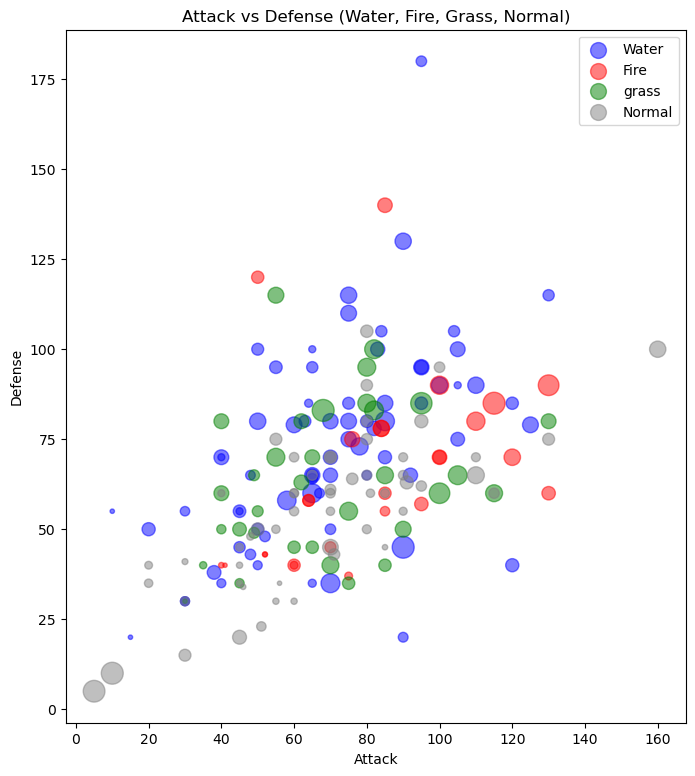

In [20]:
# Scatter plot of attack, defnese on the X and y; with HP as bubles, larger the bubble the more HP
# comparing water, fire, grass, normal types 

water_data = df_pokemon[df_pokemon['Primary Type'] == 'water']
fire_data  = df_pokemon[df_pokemon['Primary Type'] == 'fire']
grass_data  = df_pokemon[df_pokemon['Primary Type'] == 'grass']
normal_data  = df_pokemon[df_pokemon['Primary Type'] == 'normal']

min_size = 10
max_size = 250

normalized_water = np.interp(water_data['Base_HP'], (water_data['Base_HP'].min(), water_data['Base_HP'].max()), (min_size, max_size))
normalized_fire = np.interp(fire_data['Base_HP'], (fire_data['Base_HP'].min(), fire_data['Base_HP'].max()), (min_size, max_size))
normalized_grass = np.interp(grass_data['Base_HP'], (grass_data['Base_HP'].min(), grass_data['Base_HP'].max()), (min_size, max_size))
normalized_normal = np.interp(normal_data['Base_HP'], (normal_data['Base_HP'].min(), normal_data['Base_HP'].max()), (min_size, max_size))



plt.figure(figsize = (8,9))
plt.scatter(water_data['Base_Attack'], water_data['Base_Defense'], label='Water', color = "blue", s = normalized_water, cmap= 'viridis', alpha = 0.5)
plt.scatter(fire_data['Base_Attack'], fire_data['Base_Defense'], label='Fire', color = "Red", s = normalized_fire, cmap= 'viridis', alpha = 0.5)
plt.scatter(grass_data['Base_Attack'], grass_data['Base_Defense'], label='grass', color = "green", s = normalized_grass, cmap= 'viridis', alpha = 0.5)
plt.scatter(normal_data['Base_Attack'], normal_data['Base_Defense'], label='Normal', color = "gray", s = normalized_normal, cmap= 'viridis', alpha = 0.5)


# Labels for the graph
plt.xlabel("Attack")
plt.ylabel("Defense")
plt.title("Attack vs Defense (Water, Fire, Grass, Normal)")
plt.legend()
plt.show()



C:\Users\cjzan\AppData\Local\Temp\ipykernel_22304\2224058817.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  gr = df_pokemon.groupby('Primary Type')['Base_Attack', 'Base_Defense']


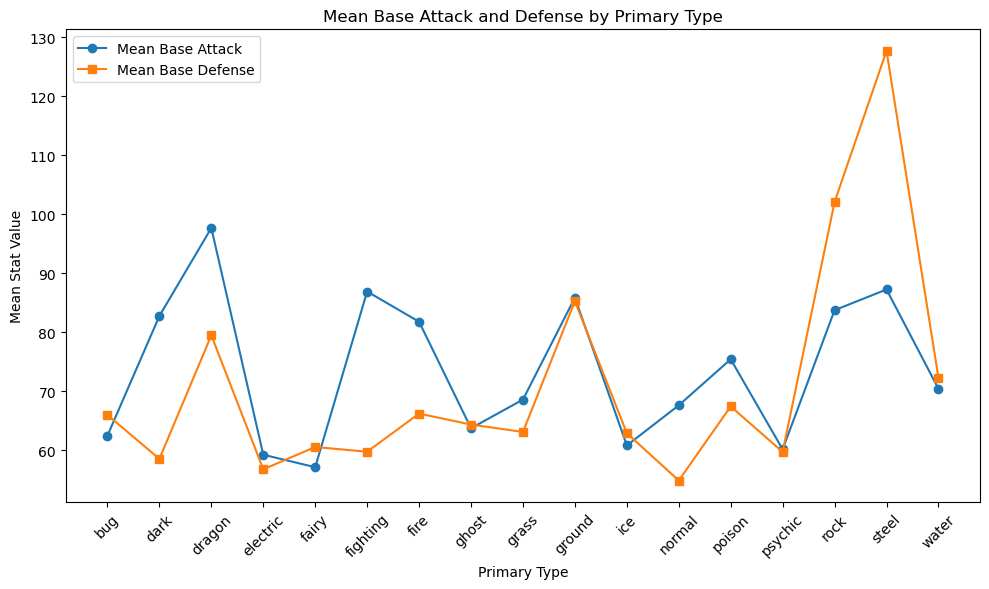

In [21]:
#Create line char of base average attack, and average defense, by type 
gr = df_pokemon.groupby('Primary Type')['Base_Attack', 'Base_Defense']
grouped_mean = gr.mean()
x = grouped_mean.index            # This will be the list of Primary Types
y_attack = grouped_mean['Base_Attack']  # Mean Base Attack values
y_defense = grouped_mean['Base_Defense'] # Mean Base Defense values
plt.figure(figsize=(10,6))

# Plot Base Attack average
plt.plot(x, y_attack, marker='o', label='Mean Base Attack')

# Plot Base Defense maverage
plt.plot(x, y_defense, marker='s', label='Mean Base Defense')

plt.xlabel('Primary Type')
plt.ylabel('Mean Stat Value')
plt.title('Mean Base Attack and Defense by Primary Type')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

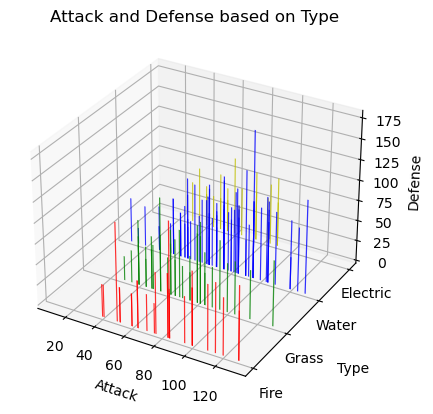

In [22]:
#This is a bar char of defense and attack, however in a 3D space so we can compare them based on type
df_pokemon['Primary Type'] = df_pokemon['Primary Type'].str.strip().str.title()
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

type_color_map = {
    "Fire": ('r', 0),
    "Grass": ('g', 1),
    "Water": ('b', 2),
    "Electric": ('y', 3)
}

for poke_type, (color, y_pos) in type_color_map.items():
    df_subset = df_pokemon[df_pokemon['Primary Type'] == poke_type]

    xs = df_subset['Base_Attack']
    zs = df_subset['Base_Defense']
    ys = [y_pos] * len(df_subset)  # match filtered rows only!

    ax.bar(xs, zs, zs=ys, zdir='y', color=color, alpha=0.8)

ax.set_xlabel('Attack')
ax.set_ylabel('Type', labelpad = 12)
ax.set_zlabel('Defense')

ax.set_yticks([v[1] for v in type_color_map.values()])
ax.set_yticklabels([k for k in type_color_map.keys()])
ax.set_title('Attack and Defense based on Type')
plt.show()


In [23]:
#create a radar chart with the 3 main starters
circle = np.linspace(0, 2*np.pi, 4, endpoint = False).tolist()
#circle
closed_circle = circle.copy()
closed_circle.append(0.0) #use 0.0 to clse the circle using append function
#closed_circle

#closed_circle

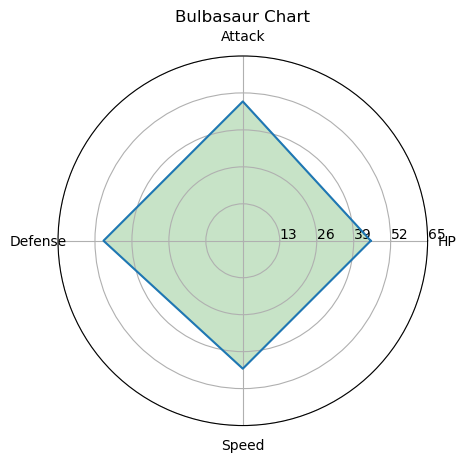

In [24]:
#define stats and skills for Bulbasaur 
attributes_Bulb = ['HP', 'Attack', 'Defense', 'Speed']
values_Bulb = [45, 49, 49, 45 ]

closed_value_Bulb = [45, 49, 49, 45, 45] #last number has to match the first number
#closed_circle
ax = plt.subplot(polar = True)

plt.xticks(circle, attributes_Bulb,)

ax.set_rlabel_position(0)

plt.yticks([13,26,39,52,65], ['13', '26', '39', '52', '65'])
plt.ylim(0,65)

ax.plot(closed_circle, closed_value_Bulb)
ax.fill(closed_circle, closed_value_Bulb, alpha =0.22, color = "Green")
plt.title('Bulbasaur Chart')

plt.show()

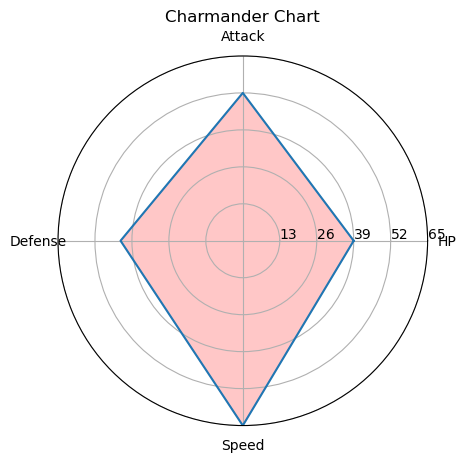

In [25]:
#radar chart of charmander 
attributes_Char = ['HP', 'Attack', 'Defense', 'Speed']
values_Char = [39, 52, 43, 65]

closed_value_char = [39, 52, 43, 65, 39] #last number has to match the first number
#closed_circle

ax = plt.subplot(polar = True)

plt.xticks(circle, attributes_Char,)

ax.set_rlabel_position(0)

plt.yticks([13,26,39,52,65], ['13', '26', '39', '52', '65'])
plt.ylim(0,65)

ax.plot(closed_circle, closed_value_char)
ax.fill(closed_circle, closed_value_char, alpha =0.22, color = "Red")
plt.title('Charmander Chart')

plt.show()

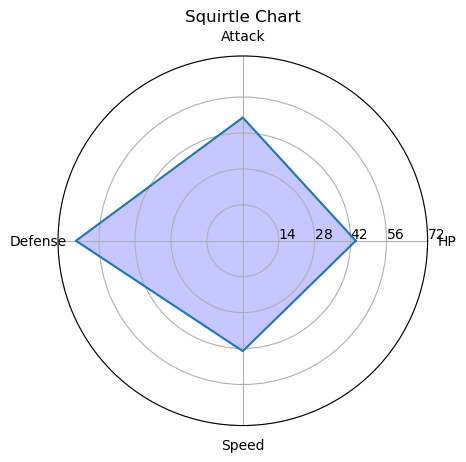

In [26]:
#Radar chart of squirtle
circle = np.linspace(0, 2*np.pi, 4, endpoint = False).tolist()
#circle
closed_circle = circle.copy()
closed_circle.append(0.0)
closed_circle
attributes_Squr = ['HP', 'Attack', 'Defense', 'Speed']
values_Squr = [44, 48, 65, 43]

closed_value_Squr = [44, 48, 65, 43, 44] #last number has to match the first number
#closed_circle

ax = plt.subplot(polar = True)

plt.xticks(circle, attributes_Squr,)

ax.set_rlabel_position(0)

plt.yticks([14,28,42,56,72], ['14', '28', '42', '56', '72'])
plt.ylim(0,72)

ax.plot(closed_circle, closed_value_Squr)
ax.fill(closed_circle, closed_value_Squr, alpha =0.22, color = "Blue")
plt.title('Squirtle Chart')

plt.show()

In [27]:
#next we will create a TSNE chart, need only the sumbers no string values 
df_numeric = df_pokemon.drop(['Name', 'Primary Type', 'Secondary Type'], axis=1)

df_numeric.shape

(386, 8)

In [28]:
#set TSME to m, use learning rate of 50, and random state of 0 so  it is repatable. 
#Learning rate of 10 moves too slow, 100 or more jumps too far and overshoots the data
m = TSNE(learning_rate=50, random_state=0)


In [29]:
#we 'fit' the relatioships between pokemon and there stats, transform those columns into just 2 dimentsion
tsne_features = m.fit_transform(df_numeric)
tsne_features[1:4, :]
#This creates 2 new demenstion for ploting 
df_numeric['x'] = tsne_features[:, 0]
df_numeric['y'] = tsne_features[:, 1]

C:\Users\cjzan\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


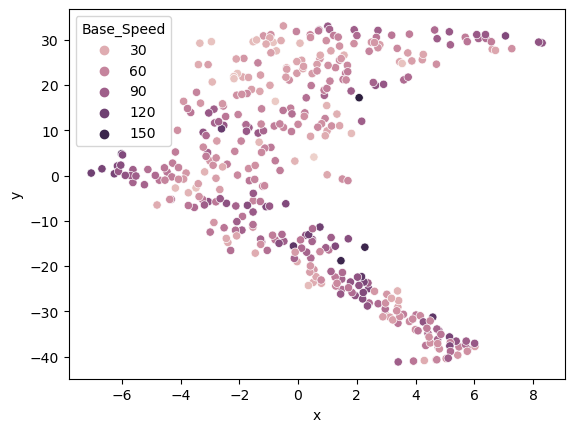

In [30]:
#plot the T SNE based on speed
sns.scatterplot(x='x', y='y',hue='Base_Speed', data=df_numeric)
plt.show()

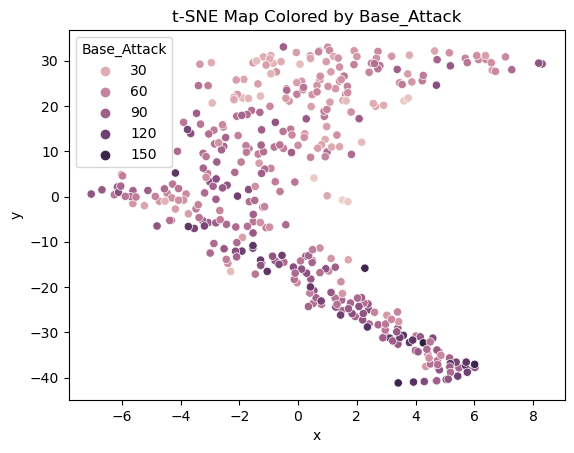

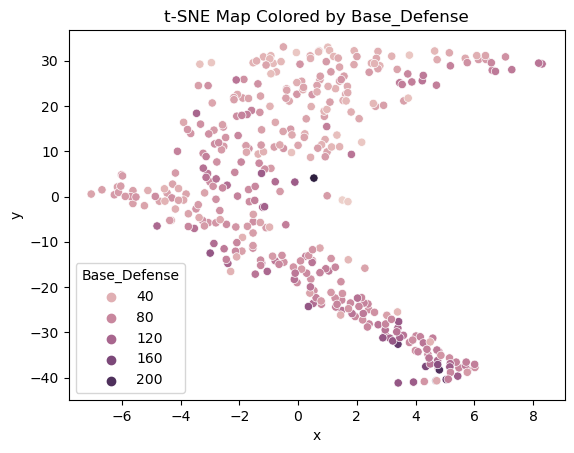

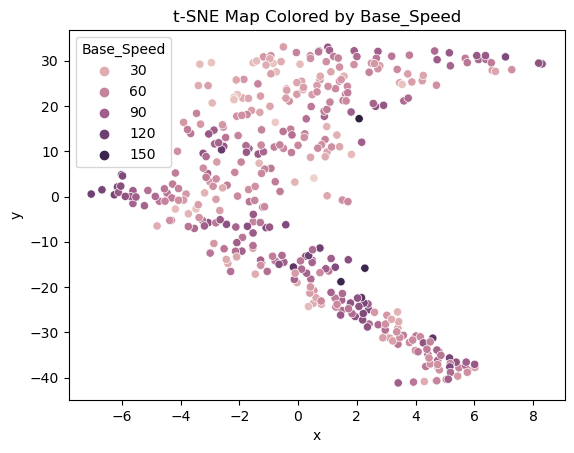

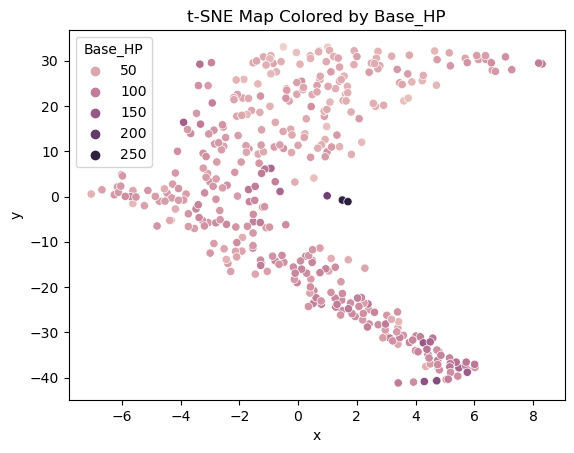

<AxesSubplot:xlabel='x', ylabel='y'>

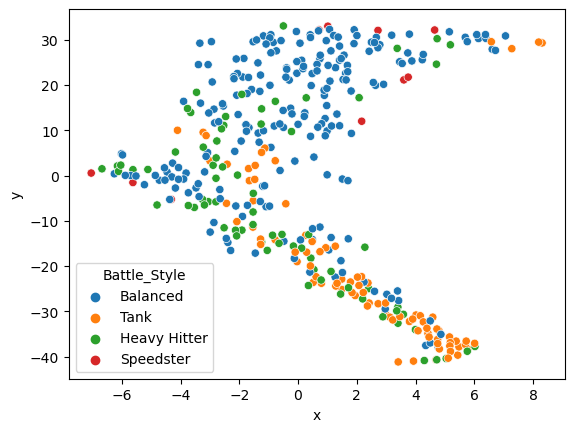

In [31]:
#Next we creat a loop of T SNE for attack, defense, speed, and HP. 
#then create a T SNE of more types of pokemon, like tank, glass canons, ect. This groups pokemon based on Fighting sytle
#NOT groups based types. So a tank can be fire type or water type but will be placed next to each other 
for stat in ['Base_Attack', 'Base_Defense', 'Base_Speed', 'Base_HP']:
    sns.scatterplot(x='x', y='y', hue=stat, data=df_numeric)
    plt.title(f't-SNE Map Colored by {stat}')
    plt.show()
def style_label(row):
    if row['Base_Defense'] > 70 and row['Base_HP'] > 70:
        return "Tank"
    elif row['Base_Speed'] > 70 and row['Base_HP'] < 40:
        return "Speedster"
    elif row['Base_Attack'] > 80:
        return "Heavy Hitter"
    else:
        return "Balanced"

df_numeric['Battle_Style'] = df_numeric.apply(style_label, axis=1)
sns.scatterplot(x='x', y='y', hue='Battle_Style', data=df_numeric)


In [32]:
#df_pokemon.to_csv('D:\Pokemon Pipeline\Pokemon_DataFrame', index = True)
df_pokemon

,Name,Height,Weight,Base_HP,Base_Attack,Base_Defense,base_special-attack,base_special-defense,Base_Speed,Primary Type,Secondary Type
Pokemon_ID,,,,,,,,,,,
1,bulbasaur,7,69,45,49,49,65,65,45,Grass,poison
2,ivysaur,10,130,60,62,63,80,80,60,Grass,poison
3,venusaur,20,1000,80,82,83,100,100,80,Grass,poison
4,charmander,6,85,39,52,43,60,50,65,Fire,NaN
5,charmeleon,11,190,58,64,58,80,65,80,Fire,NaN
...,...,...,...,...,...,...,...,...,...,...,...
382,kyogre,45,3520,100,100,90,150,140,90,Water,NaN
383,groudon,35,9500,100,150,140,100,90,90,Ground,NaN
384,rayquaza,70,2065,105,150,90,150,90,95,Dragon,flying


In [33]:
#next we will make Dataframes using SQLite. This will show skills in SQL and making SQL queries
import sqlite3
conn = sqlite3.connect("pokemon.db")
df_pokemon.to_sql("pokemon", conn, if_exists = 'replace', index = True)


386

In [34]:
query = """
SELECT *
FROM pokemon

"""
results = pd.read_sql_query(query, conn)
results.head()

,Pokemon_ID,Name,Height,Weight,Base_HP,Base_Attack,Base_Defense,base_special-attack,base_special-defense,Base_Speed,Primary Type,Secondary Type
0,1,bulbasaur,7,69,45,49,49,65,65,45,Grass,poison
1,2,ivysaur,10,130,60,62,63,80,80,60,Grass,poison
2,3,venusaur,20,1000,80,82,83,100,100,80,Grass,poison
3,4,charmander,6,85,39,52,43,60,50,65,Fire,None
4,5,charmeleon,11,190,58,64,58,80,65,80,Fire,None


In [35]:
#lets add a table of Generations, That has poke_ID (Index), Name of Region, and Generation number, 

cursor = conn.cursor()

# Clear old data, had to clear it 
cursor.execute("DELETE FROM Generation_Table")
conn.commit()

# Re-create table or create it if needed
query = """
CREATE TABLE IF NOT EXISTS Generation_Table(
    Pokemon_ID INT Primary Key, 
    Generation_Region Text,
    Generation_Number INT
)
"""
cursor.execute(query)
conn.commit()

# Insert generations by poke_id, region, and generation number, 1-151 gen 1, 152- 251 gen 2, 252-387 gen 3
generation_1_data = [(i, "Kanto", 1) for i in range(1, 152)]
cursor.executemany("INSERT INTO Generation_Table (Pokemon_ID, Generation_Region, Generation_Number) VALUES (?, ?, ?)", generation_1_data)

generation_2_data = [(i, "Johto", 2) for i in range(152, 252)]
cursor.executemany("INSERT INTO Generation_Table (Pokemon_ID, Generation_Region, Generation_Number) VALUES (?, ?, ?)", generation_2_data)

generation_3_data = [(i, "Hoenn", 3) for i in range(252, 387)]
cursor.executemany("INSERT INTO Generation_Table (Pokemon_ID, Generation_Region, Generation_Number) VALUES (?, ?, ?)", generation_3_data)
conn.commit()

# Query and print
query = """
SELECT *
FROM Generation_Table
"""
ResultsTable = cursor.execute(query).fetchall()

resultsTable = pd.read_sql_query(query, conn)
resultsTable.head()

,Pokemon_ID,Generation_Region,Generation_Number
0,1,Kanto,1
1,2,Kanto,1
2,3,Kanto,1
3,4,Kanto,1
4,5,Kanto,1


In [36]:
query = """
SELECT pokemon.*, Generation_Table.Generation_Region, Generation_Table.Generation_Number
FROM pokemon
LEFT JOIN Generation_Table
ON pokemon.Pokemon_ID = Generation_Table.Pokemon_ID
"""

results = pd.read_sql_query(query, conn)

# Set Pokemon_ID as the index
results = results.set_index('Pokemon_ID')

results.head(252)



,Name,Height,Weight,Base_HP,Base_Attack,Base_Defense,base_special-attack,base_special-defense,Base_Speed,Primary Type,Secondary Type,Generation_Region,Generation_Number
Pokemon_ID,,,,,,,,,,,,,
1,bulbasaur,7,69,45,49,49,65,65,45,Grass,poison,Kanto,1
2,ivysaur,10,130,60,62,63,80,80,60,Grass,poison,Kanto,1
3,venusaur,20,1000,80,82,83,100,100,80,Grass,poison,Kanto,1
4,charmander,6,85,39,52,43,60,50,65,Fire,None,Kanto,1
5,charmeleon,11,190,58,64,58,80,65,80,Fire,None,Kanto,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
248,tyranitar,20,2020,100,134,110,95,100,61,Rock,dark,Johto,2
249,lugia,52,2160,106,90,130,90,154,110,Psychic,flying,Johto,2
250,ho-oh,38,1990,106,130,90,110,154,90,Fire,flying,Johto,2


In [37]:
#lets add a table of eveulations, That has poke_ID (Index),can Evolve, number of evultions and final form, 

cursor = conn.cursor()

# Clear old data, had to clear it 
#cursor.execute("DELETE FROM Evolve_Table")
conn.commit()

# Re-create table or create it if needed
query = """
CREATE TABLE IF NOT EXISTS Evolve_Table(
    Pokemon_ID INT Primary Key, 
     Can_Evolve Boolean,
     Number_of_Evolutions INT, 
     Is_Final_Form Boolean
)
"""

cursor.execute(query)
conn.commit()

In [38]:
# as boolean vlaues are 1(yes or true) or 0(no or false), make it a index with list 
evolution_data = [
    (1, 1, 2, 0), (2, 1, 1, 0), (3, 0, 0, 1),
    (4, 1, 2, 0), (5, 1, 1, 0), (6, 0, 0, 1),
    (7, 1, 2, 0), (8, 1, 1, 0), (9, 0, 0, 1),
    (10, 1, 2, 0), (11, 1, 1, 0), (12, 0, 0, 1),
    (13, 1, 2, 0), (14, 1, 1,0), (15,0, 0, 1), (16, 1, 2, 0), (17, 1, 1, 0), (18, 0, 0, 1), (19, 1,1,0), (20, 0,0,1),
    (21, 1, 1, 0), (22, 0, 0, 1), (23, 1, 1, 0), (24, 0, 0, 1), (25, 1, 1, 0), (26, 0, 0, 1), (27, 1, 1, 0), (28, 0, 0, 1), (29 , 1,2,0), (30, 1,1,0),
    (31, 0,0,1), (32, 1,2,0), (33, 1,1,0), (34, 0,0,1), (35, 1,1,0), (36, 0,0,1), (37, 1,1,0), (38,0,0,1), (39, 1,1,0), (40,0,0,1),
    (41, 1,1,0), (42, 0,0,1), (43, 1,2,0), (44,1,1,0), (45,0,0,1), (46, 1,1,0), (47,0,0,1), (48, 1,1,0), (49,0,0,1), (50, 1,1,0),
    (51,0,0,1), (52, 1,1,0), (53,0,0,1), (54, 1,1,0), (55,0,0,1), (56, 1,1,0), (57,0,0,1), (58, 1,1,0), (59, 0,0,1), (60, 1,2,0),
    (61, 1,1,0), (62,0,0,1), (63, 1,2,0), (64, 1,1,0), (65,0,0,1), (66, 1,2,0), (67, 1,1,0), (68,0,0,1), (69, 1,2,0), (70, 1,1,0),
    (71,0,0,1), (72, 1,1,0), (73,0,0,1), (74, 1,2,0), (75, 1,1,0), (76,0,0,1), (77, 1,1,0), (78,0,0,1), (79, 1,1,0), (80,0,0,1),
    (81, 1,1,0), (82,0,0,1), (83,0,0,1), (84, 1,1,0), (85,0,0,1), (86, 1,1,0), (87,0,0,1), (88, 1,1,0), (89,0,0,1), (90, 1,1,0),
    (91,0,0,1), (92, 1,2,0), (93, 1,1,0), (94,0,0,1), (95,0,0,1), (96,0,0,1), (97,0,0,1), (98, 1,1,0), (99,0,0,1), (100, 1,1,0),
    (101,0,0,1), (102, 1,1,0), (103,0,0,1), (104, 1,1,0), (105,0,0,1), (106,0,0,1), (107,0,0,1), (108,0,0,1), (109, 1,1,0), (110,0,0,1),
    (111, 1,1,0), (112,0,0,1), (113,0,0,1), (114,0,0,1), (115,0,0,1), (116, 1,1,0), (117,0,0,1), (118,0,0,1), (119,0,0,1), (120, 1,1,0),
    (121,0,0,1), (122,0,0,1), (123,0,0,1), (124,0,0,1), (125,0,0,1), (126,0,0,1), (127,0,0,1), (128,0,0,1), (129, 1,1,0), (130,0,0,1),
    (131,0,0,1), (132,0,0,1), (133, 1,1,0), (134,0,0,1), (135,0,0,1), (136,0,0,1), (137,0,0,1), (138, 1,1,0), (139,0,0,1), (140, 1,1,0),
    (141,0,0,1), (142,0,0,1), (143,0,0,1), (144,0,0,1), (145,0,0,1), (146,0,0,1), (147, 1, 2, 0), (148, 1, 1, 0), (149,0,0,1), (150,0,0,1),
    (151,0,0,1), (152, 1, 2, 0), (153, 1, 1, 0), (154,0,0,1), (155, 1, 2, 0), (156, 1, 1, 0), (157,0,0,1), (158, 1, 2, 0), (159, 1, 1, 0), (160,0,0,1),
    (161, 1, 1, 0), (162,0,0,1), (163, 1, 1, 0), (164,0,0,1), (165, 1, 1, 0), (166,0,0,1), (167, 1, 1, 0), (168,0,0,1), (169,0,0,1), (170, 1, 1, 0),
    (171,0,0,1), (172,0,0,1), (173,0,0,1), (174,0,0,1), (175, 1, 1, 0), (176,0,0,1), (177, 1, 1, 0), (178,0,0,1), (179, 1, 2, 0), (180, 1, 1, 0),
    (181,0,0,1), (182,0,0,1), (183, 1, 1, 0), (184,0,0,1), (185,0,0,1), (186,0,0,1), (187, 1, 2, 0), (188, 1, 1, 0), (189,0,0,1), (190,0,0,1),
    (191, 1, 1, 0), (192,0,0,1), (193,0,0,1), (194, 1, 1, 0), (195,0,0,1), (196,0,0,1), (197,0,0,1), (198,0,0,1), (199,0,0,1), (200,0,0,1),
    (201,0,0,1), (202,0,0,1), (203,0,0,1), (204, 1, 1, 0), (205,0,0,1), (206, 1, 1, 0), (207,0,0,1), (208,0,0,1), (209, 1, 1, 0), (210,0,0,1),
    (211,0, 0,1), (212,0,0,1), (213,0,0,1), (214,0,0,1), (215,0,0,1), (216, 1, 1, 0), (217,0,0,1), (218, 1, 1, 0), (219,0,0,1), (220, 1, 1, 0),
    (221,0,0,1), (222,0,0,1), (223,0,0,1), (224,0,0,1), (225,0,0,1), (226,0,0,1), (227,0,0,1), (228, 1, 1, 0), (229,0,0,1), (230,0,0,1),
    (231, 1, 1, 0), (232,0,0,1), (233,0,0,1), (234,0,0,1), (235,0,0,1), (236, 1, 1, 0), (237,0,0,1), (238,0,0,1), (239,0,0,1), (240,0,0,1),
    (241,0,0,1), (242,0,0,1), (243,0,0,1), (244,0,0,1), (245,0,0,1), (246, 1, 2, 0), (247, 1, 1, 0), (248,0,0,1), (249,0,0,1), (250,0,0,1),
    (251,0,0,1), (252, 1, 2, 0), (253, 1, 1, 0), (254,0,0,1), (255, 1, 2, 0), (256, 1, 1, 0), (257,0,0,1), (258, 1, 2, 0), (259, 1, 1, 0), (260,0,0,1),
    (261, 1, 1, 0), (262,0,0,1), (263, 1, 1, 0), (264,0,0,1), (265, 1, 2, 0), (266, 1, 1, 0), (267,0,0,1), (268, 1, 1, 0), (269,0,0,1), (270, 1, 2, 0),
    (271, 1, 1, 0), (272,0,0,1), (273, 1, 2, 0), (274, 1, 1, 0), (275,0,0,1), (276, 1, 1, 0), (277,0,0,1), (278, 1, 1, 0), (279,0,0,1), (280, 1, 2, 0),
    (281, 1, 1, 0), (282,0,0,1), (283, 1, 1, 0), (284,0,0,1), (285, 1, 1, 0), (286,0,0,1), (287, 1,2, 0), (288, 1, 1, 0), (289,0,0,1), (290, 1, 2, 0),
    (291, 1, 1, 0), (292,0,0,1), (293, 1, 2, 0), (294, 1, 1, 0), (295,0,0,1), (296, 1, 1, 0), (297,0,0,1), (298,0,0,1), (299,0,0,1), (300, 1, 1, 0),
    (301,0,0,1), (302,0,0,1), (303,0,0,1), (304, 1, 2, 0), (305, 1, 1, 0), (306,0,0,1), (307, 1, 1, 0), (308,0,0,1), (309, 1, 1, 0), (310,0,0,1),
    (311,0,0,1), (312,0,0,1), (313,0,0,1), (314,0,0,1), (315,0,0,1), (316, 1, 1, 0), (317,0,0,1), (318, 1, 1, 0), (319,0,0,1), (320, 1, 1, 0),
    (321,0,0,1), (322, 1, 1, 0), (323,0,0,1), (324,0,0,1), (325, 1, 1, 0), (326,0,0,1), (327,0,0,1), (328, 1, 2, 0), (329, 1, 1, 0), (330,0,0,1),
    (331, 1, 1, 0), (332,0,0,1), (333, 1, 1, 0), (334,0,0,1), (335,0,0,1), (336,0,0,1), (337,0,0,1), (338,0,0,1), (339, 1, 1, 0), (340,0,0,1),
    (341, 1, 1, 0), (342,0,0,1), (343, 1, 1, 0), (344,0,0,1), (345, 1, 1, 0), (346,0,0,1), (347, 1, 1, 0), (348,0,0,1), (349, 1, 1, 0), (350,0,0,1),
    (351,0,0,1), (352,0,0,1), (353, 1, 1, 0), (354,0,0,1), (355, 1, 1, 0), (356,0,0,1), (357,0,0,1), (358,0,0,1), (359,0,0,1), (360,0,0,1),
    (361, 1, 1, 0), (362,0,0,1), (363, 1, 2, 0), (364, 1, 1, 0), (365,0,0,1), (366, 1, 2, 0), (367, 1, 1, 0), (368,0,0,1), (369,0,0,1), (370,0,0,1),
    (371, 1, 2, 0), (372, 1, 1, 0), (373,0,0,1), (374, 1, 2, 0), (375, 1, 1, 0), (376,0,0,1), (377,0,0,1), (378,0,0,1), (379,0,0,1), (380,0,0,1),
    (381,0,0,1), (382,0,0,1), (383,0,0,1), (384,0,0,1), (385,0,0,1), (386,0,0,1)
]

cursor.execute("DELETE FROM Evolve_Table")
conn.commit()
cursor.executemany("""
    INSERT INTO Evolve_Table (Pokemon_ID, Can_Evolve, Number_of_Evolutions, Is_Final_Form)
    VALUES (?, ?, ?, ?)
""", evolution_data)
conn.commit()

In [39]:
# Query and print the data, will have to  replace 1 with 'yes' and 0 with 'No' in both can_Evolve and Final_Form colums

query = """
SELECT *
FROM Evolve_Table
"""
EVOTable = cursor.execute(query).fetchall()

EVOTable = pd.read_sql_query(query, conn)
EVOTable['Can_Evolve'] = EVOTable['Can_Evolve'].replace({1: 'Yes', 0: 'No'})
EVOTable['Is_Final_Form'] = EVOTable['Is_Final_Form'].replace({1: 'Yes', 0: 'No'})

EVOTable.head()


,Pokemon_ID,Can_Evolve,Number_of_Evolutions,Is_Final_Form
0,1,Yes,2,No
1,2,Yes,1,No
2,3,No,0,Yes
3,4,Yes,2,No
4,5,Yes,1,No


In [40]:
#Make a table that joins on pokemon_ID with Evolve data and stats data
query = """
SELECT pokemon.*, Evolve_Table.Can_Evolve, Evolve_Table.Number_of_Evolutions, Evolve_Table.IS_Final_Form
FROM pokemon
LEFT JOIN Evolve_Table
ON pokemon.Pokemon_ID = Evolve_Table.Pokemon_ID
"""

results = pd.read_sql_query(query, conn)

# Set Pokemon_ID as the index
results = results.set_index('Pokemon_ID')

results.head()

,Name,Height,Weight,Base_HP,Base_Attack,Base_Defense,base_special-attack,base_special-defense,Base_Speed,Primary Type,Secondary Type,Can_Evolve,Number_of_Evolutions,Is_Final_Form
Pokemon_ID,,,,,,,,,,,,,,
1,bulbasaur,7,69,45,49,49,65,65,45,Grass,poison,1,2,0
2,ivysaur,10,130,60,62,63,80,80,60,Grass,poison,1,1,0
3,venusaur,20,1000,80,82,83,100,100,80,Grass,poison,0,0,1
4,charmander,6,85,39,52,43,60,50,65,Fire,None,1,2,0
5,charmeleon,11,190,58,64,58,80,65,80,Fire,None,1,1,0


In [41]:
#Make a query that joins all three tables together with ALL Data, Stats, Generation, and Evoluations
query = """
SELECT 
    pokemon.*, 
    Generation_Table.Generation_Region, 
    Generation_Table.Generation_Number,
    Evolve_Table.Can_Evolve, 
    Evolve_Table.Number_of_Evolutions, 
    Evolve_Table.Is_Final_Form
FROM pokemon
LEFT JOIN Generation_Table ON pokemon.Pokemon_ID = Generation_Table.Pokemon_ID
LEFT JOIN Evolve_Table ON pokemon.Pokemon_ID = Evolve_Table.Pokemon_ID
"""
results = pd.read_sql_query(query, conn)
results['Can_Evolve'] = results['Can_Evolve'].replace({1: 'Yes', 0: 'No'})
results['Is_Final_Form'] = results['Is_Final_Form'].replace({1: 'Yes', 0: 'No'})

results = results.set_index('Pokemon_ID')
#save results as a database
results.to_sql("pokemon", conn, if_exists = 'replace', index=False)
results.head()

,Name,Height,Weight,Base_HP,Base_Attack,Base_Defense,base_special-attack,base_special-defense,Base_Speed,Primary Type,Secondary Type,Generation_Region,Generation_Number,Can_Evolve,Number_of_Evolutions,Is_Final_Form
Pokemon_ID,,,,,,,,,,,,,,,,
1,bulbasaur,7,69,45,49,49,65,65,45,Grass,poison,Kanto,1,Yes,2,No
2,ivysaur,10,130,60,62,63,80,80,60,Grass,poison,Kanto,1,Yes,1,No
3,venusaur,20,1000,80,82,83,100,100,80,Grass,poison,Kanto,1,No,0,Yes
4,charmander,6,85,39,52,43,60,50,65,Fire,None,Kanto,1,Yes,2,No
5,charmeleon,11,190,58,64,58,80,65,80,Fire,None,Kanto,1,Yes,1,No


In [42]:
#filter results, where primary type is Fire
query = """
SELECT * 
FROM pokemon
WHERE "Primary Type" = 'Fire'
"""
df_fire = pd.read_sql_query(query, conn)
df_fire

,Name,Height,Weight,Base_HP,Base_Attack,Base_Defense,base_special-attack,base_special-defense,Base_Speed,Primary Type,Secondary Type,Generation_Region,Generation_Number,Can_Evolve,Number_of_Evolutions,Is_Final_Form
0,charmander,6,85,39,52,43,60,50,65,Fire,None,Kanto,1,Yes,2,No
1,charmeleon,11,190,58,64,58,80,65,80,Fire,None,Kanto,1,Yes,1,No
2,charizard,17,905,78,84,78,109,85,100,Fire,flying,Kanto,1,No,0,Yes
3,vulpix,6,99,38,41,40,50,65,65,Fire,None,Kanto,1,Yes,1,No
4,ninetales,11,199,73,76,75,81,100,100,Fire,None,Kanto,1,No,0,Yes
5,growlithe,7,190,55,70,45,70,50,60,Fire,None,Kanto,1,Yes,1,No
6,arcanine,19,1550,90,110,80,100,80,95,Fire,None,Kanto,1,No,0,Yes
7,ponyta,10,300,50,85,55,65,65,90,Fire,None,Kanto,1,Yes,1,No
8,rapidash,17,950,65,100,70,80,80,105,Fire,None,Kanto,1,No,0,Yes
9,magmar,13,445,65,95,57,100,85,93,Fire,None,Kanto,1,No,0,Yes


In [43]:
#filter results with Fire and water as secondary Type

query = """
SELECT * 
FROM pokemon
WHERE "Secondary Type" = 'fire' OR "Secondary Type" = 'water'
"""
df_secondary = pd.read_sql_query(query, conn)
df_secondary

,Name,Height,Weight,Base_HP,Base_Attack,Base_Defense,base_special-attack,base_special-defense,Base_Speed,Primary Type,Secondary Type,Generation_Region,Generation_Number,Can_Evolve,Number_of_Evolutions,Is_Final_Form
0,omanyte,4,75,35,40,100,90,55,35,Rock,water,Kanto,1,Yes,1,No
1,omastar,10,350,70,60,125,115,70,55,Rock,water,Kanto,1,No,0,Yes
2,kabuto,5,115,30,80,90,55,45,55,Rock,water,Kanto,1,Yes,1,No
3,kabutops,13,405,60,115,105,65,70,80,Rock,water,Kanto,1,No,0,Yes
4,houndour,6,108,45,60,30,80,50,65,Dark,fire,Johto,2,Yes,1,No
5,houndoom,14,350,75,90,50,110,80,95,Dark,fire,Johto,2,No,0,Yes
6,surskit,5,17,40,30,32,50,52,65,Bug,water,Hoenn,3,Yes,1,No
7,spheal,8,395,70,40,50,55,50,25,Ice,water,Hoenn,3,Yes,2,No
8,sealeo,11,876,90,60,70,75,70,45,Ice,water,Hoenn,3,Yes,1,No
9,walrein,14,1506,110,80,90,95,90,65,Ice,water,Hoenn,3,No,0,Yes


In [44]:
#lets see if there is any pokemon that has attack, defense, speed >= 90, a powerful pokemon
query = """
SELECT Name, Base_Attack, Base_Defense, Base_Speed
FROM pokemon
WHERE Base_Attack >= 90 
  AND Base_Defense >= 90 
  AND Base_Speed >= 90
ORDER BY Base_Attack DESC
"""
powerful_pokemon_df = pd.read_sql_query(query, conn)
powerful_pokemon_df

,Name,Base_Attack,Base_Defense,Base_Speed
0,slaking,160,100,100
1,groudon,150,140,90
2,rayquaza,150,90,95
3,ho-oh,130,90,90
4,mewtwo,110,90,130
5,tauros,100,95,110
6,moltres,100,90,90
7,mew,100,100,100
8,celebi,100,100,100
9,kyogre,100,90,90


In [45]:
#lets filer based on speed, speed faster then 100
query = """
SELECT NAME, Base_Speed
From pokemon
WHERE Base_Speed >= 100
"""
df_speed = pd.read_sql_query(query, conn)
df_speed

,Name,Base_Speed
0,charizard,100
1,pidgeot,101
2,fearow,100
3,raichu,110
4,ninetales,100
5,dugtrio,120
6,persian,115
7,kadabra,105
8,alakazam,120
9,tentacruel,100


In [46]:
#lets count the number of each pokemon and order them most to least 
query = """
SELECT Generation_Region, Generation_Number, COUNT(*) as Count
FROM pokemon
GROUP BY Generation_Region, Generation_Number 
Order By Count Desc
"""
df_generation_count = pd.read_sql_query(query, conn)
df_generation_count


,Generation_Region,Generation_Number,Count
0,Kanto,1,151
1,Hoenn,3,135
2,Johto,2,100


In [47]:
#lets count the number of each pokemon type and order them most to least 
query = """
SELECT [Primary Type], COUNT(*) as Count
FROM pokemon
GROUP BY [Primary Type]
Order By Count Desc
"""
df_type_count = pd.read_sql_query(query, conn)
df_type_count


,Primary Type,Count
0,Water,70
1,Normal,55
2,Bug,34
3,Grass,33
4,Fire,26
5,Psychic,23
6,Rock,21
7,Electric,19
8,Poison,18
9,Ground,17


In [48]:
#lets count the number of each pokemon  primary type and secondary type, then order them most to least 
query = """
SELECT [Primary Type], [Secondary Type], COUNT(*) as Count
FROM pokemon
Where [Secondary Type] != 'None'
GROUP BY [Primary Type],[Secondary Type]
Order By Count Desc
"""
df_both_type_count = pd.read_sql_query(query, conn)
df_both_type_count

,Primary Type,Secondary Type,Count
0,Normal,flying,13
1,Grass,poison,10
2,Bug,flying,8
3,Bug,poison,8
4,Rock,ground,6
...,...,...,...
64,Steel,fairy,1
65,Steel,flying,1
66,Steel,ground,1
67,Water,dragon,1


In [49]:
query = """
SELECT [Primary Type], AVG(Base_Speed) AS avg_speed
FROM pokemon
GROUP BY [Primary Type]
ORDER BY Base_Speed DESC
"""

results_speed = pd.read_sql_query(query, conn)
results_speed

,Primary Type,avg_speed
0,Ice,61.250000
1,Psychic,80.782609
2,Electric,87.631579
3,Ghost,66.250000
4,Fighting,60.230769
5,Fire,71.192308
6,Dark,73.444444
7,Normal,66.709091
8,Poison,61.833333
9,Dragon,79.500000


In [50]:
#lets see if any pokemon have attack, defense, and speed of 70 or greater, a POWERFUL GROUP pokemon
query = """
SELECT [Primary Type],
       AVG(Base_Attack) AS avg_attack,
       AVG(Base_Defense) AS avg_defense,
       AVG(Base_Speed) AS avg_speed
FROM pokemon
GROUP BY [Primary Type]
HAVING AVG(Base_Attack) >= 70 
   AND AVG(Base_Defense) >= 70 
   AND AVG(Base_Speed) >= 70
ORDER BY avg_attack DESC
"""
powerful_types_df = pd.read_sql_query(query, conn)
powerful_types_df





,Primary Type,avg_attack,avg_defense,avg_speed
0,Dragon,97.7,79.5,79.5


In [51]:
#lets count the number of each pokemon  primary type and secondary type, then order them most to least, cut off at 5 
query = """
SELECT [Primary Type], [Secondary Type], COUNT(*) as Count
FROM pokemon
Where [Secondary Type] != 'None'
GROUP BY [Primary Type],[Secondary Type]
HAVING Count >= 5
Order By Count Desc
"""
df_both_type_count_group = pd.read_sql_query(query, conn)
df_both_type_count_group

,Primary Type,Secondary Type,Count
0,Normal,flying,13
1,Grass,poison,10
2,Bug,flying,8
3,Bug,poison,8
4,Rock,ground,6
5,Water,ground,6


In [54]:
results.to_csv(r'D:\Pokemon Pipeline\Pokemon_DataFrame.csv', index=True)
